## Required Data Downloads:

[Kaggle facial keypoints dataset](https://www.kaggle.com/c/facial-keypoints-detection/data) (download will be named all.zip)

In [58]:
import zipfile
import numpy as np
import os
from skimage.transform import resize
from sklearn.model_selection import train_test_split

In [59]:
def unpack(filename, current_file_directory = '', extract_to_directory = ''):
    """
    Extracts the zipfile in the same location of the 
    """
    with zipfile.ZipFile(os.path.join(current_file_directory,filename)) as (zf):
        zf.extractall(path = extract_to_directory)

In [60]:
MAX_IMG_VALUE = 255
IMG_SHAPE = (1,96,96,1) # IMG_SHAPE[3] == 1 because these are greyscale imgs

In [61]:
cwd = os.getcwd()
data_dir = os.path.join(cwd,'data')
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [62]:
#be careful to remember where you extract to and from if you're not doing so in the working directory.

unpack('all.zip', extract_to_directory = data_dir)
unpack('test.zip', current_file_directory = data_dir, extract_to_directory = data_dir)
unpack('training.zip', current_file_directory = data_dir, extract_to_directory = data_dir)

# Keep the base all.zip files, but remove the sub zip files and just keep the final data
try:
    os.remove(os.path.join(data_dir, 'test.zip'))
except OSError:
    print('test.zip didn\'t get unpacked from all.zip')

try:
    os.remove(os.path.join(data_dir, 'training.zip'))
except OSError:
    print('training.zip didn\'t get unpacked from all.zip')

Now we have files:
* IdLookupTable.csv
* training.csv
* test.csv
* SampleSubmission.csv (not something we'll use)


In [63]:
with open(os.path.join(data_dir,'IdLookupTable.csv'), 'r') as IdLookupTable_csv:
    print(IdLookupTable_csv.readline())
    print(IdLookupTable_csv.readline())
    print(IdLookupTable_csv.readline())
    print(IdLookupTable_csv.readline())

RowId,ImageId,FeatureName,Location

1,1,left_eye_center_x

2,1,left_eye_center_y

3,1,right_eye_center_x



In [64]:
with open(os.path.join(data_dir,'training.csv'), 'r') as training:
    print(training.readline())
    print(np.array([int(num)/MAX_IMG_VALUE for num in training.readline().split(',')[-1].split(' ')]).reshape(96,96))
    print(np.array([float(pt) for pt in training.readline().split(',')[:-1]]))
    print(np.array([float(pt) for pt in training.readline().split(',')[:-1]]).shape)

left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image

[[0.93333333 0.9254902  0.92941176 ... 0.98039216 0.98039216 0.98039216]
 [0.92156863 0.93333333 0.9254902  ... 0.97647059 0.98039216 0.98431373]
 [0.92941176 0.9254902  0.92941176 ... 0.98431373 0.98431373 0.98039216]
 ...
 [0.72941176 0.71764706 0.70980392 ... 0.20392157 0.22352941 0.23529412]
 [0.74117647 0.73725

In [65]:
with open(os.path.join(data_dir,'test.csv'), 'r') as training:
    print(training.readline())
    print(training.readline().split(','))
    #print(np.array([int(num)/MAX_IMG_VALUE for num in training.readline().split(',')[-1].split(' ')]).reshape(96,96))
    #print(np.array([float(pt) for pt in training.readline().split(',')[:-1]]))
    #print(np.array([float(pt) for pt in training.readline().split(',')[:-1]]).shape)

ImageId,Image

['1', '182 183 182 182 180 180 176 169 156 137 124 103 79 62 54 56 58 48 49 45 39 37 42 43 52 61 78 93 104 107 114 115 117 122 120 122 118 114 115 118 117 123 122 122 112 113 118 125 124 122 109 101 96 102 108 107 100 89 76 67 58 48 44 36 32 21 12 5 15 21 24 33 32 41 52 63 71 90 106 121 152 173 180 183 182 182 183 182 182 181 182 182 183 182 182 182 182 181 181 181 182 179 177 162 136 106 84 64 49 44 40 50 50 42 36 33 32 43 51 67 77 94 106 121 124 128 127 126 128 128 129 126 126 122 128 123 128 123 129 127 133 123 128 129 135 127 122 111 115 118 120 121 118 114 107 107 99 89 74 70 59 47 29 18 16 22 25 25 34 39 45 51 52 60 84 97 124 157 175 181 183 182 183 182 184 181 183 183 183 182 182 182 182 181 180 183 182 180 176 152 111 77 59 45 36 40 51 48 37 29 29 33 45 61 81 95 107 113 120 126 129 128 132 132 130 132 132 132 131 133 130 132 129 130 133 137 136 137 135 137 137 134 129 125 126 131 131 128 128 124 124 122 121 111 105 98 86 72 62 42 27 20 19 14 15 27 40 36 27 41 56 

In [66]:
def parse_imgs_and_keypoints(file, file_path = '', resize_h = 100, resize_w = 100, max_imgs = None):
    with open(os.path.join(file_path,file), 'r') as data:
        #remove header
        data.readline()
        
        images = np.empty((0,96,96,1), float)
        key_points = np.empty([0,30], float)
        
        num_imgs = 0
        for line in data:
            if len(line.split(',')) <31:
                continue
            row = line.split(',')
            
   
            row_pts = np.array([float(pt) if pt != '' else None for pt in row[:-1]])
  
            
            image = np.array([float(num)/MAX_IMG_VALUE for num in row[-1].split(' ')])

            image = image.reshape(IMG_SHAPE)
            h, w = image.shape[1:3]

            #try:
            #    images = np.append(images, image, axis = 0)
            #except:
            #    print(image.shape)
            
            pts_scaled = np.array([row_pts], dtype = np.float32)
            pts_scaled = np.array([pts_scaled[i]/h if i %2 ==0 else pts_scaled[i]/w for i in range(len(pts_scaled))])
            pts_scaled -= 0.5
            images = np.vstack((images,image))
            
            key_points = np.vstack((key_points, pts_scaled))
            
            num_imgs += 1
            if max_imgs is not None and num_imgs >= max_imgs:
                break
    return key_points, images

In [67]:
key_pts, imgs = parse_imgs_and_keypoints(os.path.join(data_dir,'training.csv'), max_imgs = 100)

In [68]:
imgs.shape

(100, 96, 96, 1)

In [69]:
key_pts.shape

(100, 30)

In [70]:
key_pts[0]

array([ 0.18784958, -0.09372631, -0.18513533, -0.12060753,  0.12064666,
       -0.087006  ,  0.26177448, -0.08364585, -0.12128571, -0.11052707,
       -0.25569928, -0.11052707,  0.09326315, -0.19756618,  0.33569926,
       -0.16429022, -0.08096242, -0.19789249, -0.32962108, -0.19117218,
       -0.03728572,  0.09444588,  0.13745111,  0.33302259, -0.20193234,
        0.30613536, -0.04882705,  0.25974435, -0.05072179,  0.38006014])

In [71]:
def parse_test_data():
    # The test data doesn't contain key point information. It's what you're tested against in the Kaggle competition
    # I just want the dataset so I'll make my own training and test data
    pass

In [72]:
imgs_train, imgs_test, key_pts_train, key_pts_test = train_test_split(imgs, key_pts, test_size = .33)

In [73]:
imgs_train.shape

(67, 96, 96, 1)

array([ 0.17013019, -0.13950753, -0.15739727, -0.11195889,  0.12115067,
       -0.13032463,  0.21910268, -0.14256918, -0.10842466, -0.10889795,
       -0.22167808, -0.10889795,  0.09666437, -0.19460616,  0.27726716,
       -0.22827742, -0.07781506, -0.17623973, -0.30126715, -0.16093493,
        0.03238356,  0.12986302,  0.14870548,  0.24923974, -0.12372601,
        0.2676096 ,  0.02626026,  0.22781509,  0.02932191,  0.30739731])

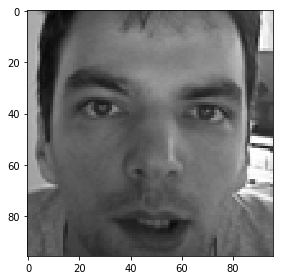

In [74]:
# Example image
%matplotlib inline
from skimage.io import imshow
imshow(img_train[3,:,:,0])
key_pts_train[3]

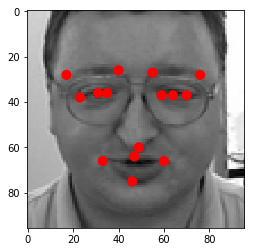

In [88]:
import matplotlib.pyplot as plt
# Circle may be useful for drawing points on face
# See matplotlib documentation for more info
from matplotlib.patches import Circle

def visualize_points(img, points):
    # Write here function which obtains image and normalized
    # coordinates and visualizes points on image
    cur_img = img[:,:,0]
    cur_points = points + .5
    cur_points *= cur_img.shape[0]
    fig, ax = plt.subplots(1)
    ax.set_aspect('equal')
    
    ax.imshow(cur_img, cmap = "gray")
    for i in range(0,len(cur_points),2):
        c = Circle((int(cur_points[i]), int(cur_points[i+1])), 2, color = 'red')
        #print((int(cur_points[i]), int(cur_points[i+1])))
        ax.add_patch(c)
    
    plt.show()
    
    
visualize_points(imgs_train[0], key_pts_train[0])

In [79]:
imgs_train[3].shape

(96, 96, 1)

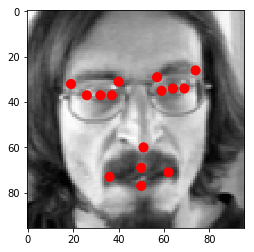

In [89]:
visualize_points(imgs_train[3], key_pts_train[3])

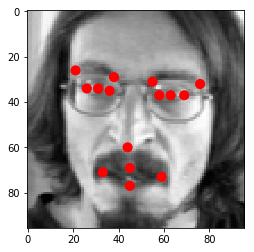

In [81]:
def flip_img(img, points):
    
    img_flipped = np.flip(img, axis = 1)
    
    #flipped_points = np.array([-(points[i] - int(img.shape[0]/2)) + int(img.shape[0]/2) if i%2 == 0 else points[i] for i in range(len(points))])
    #flipped_points = np.array([-points[i] if i%2 == 0 else points[i] for i in range(len(points))])
    flipped_points = points[:]
    flipped_points[::2] = -1*points[::2]
    return(img_flipped, flipped_points)
        

f_img, f_points = flip_img(imgs_train[3,:,:,0], key_pts_train[3])
visualize_points(f_img, f_points)

In [82]:
key_pts_train[1]

array([ 1.89849555e-01, -1.03530973e-01, -1.97734505e-01, -1.11442477e-01,
        1.38442457e-01, -9.56194699e-02,  2.57088482e-01, -9.56194699e-02,
       -1.30495578e-01, -1.03530973e-01, -2.57053077e-01, -1.03530973e-01,
        6.72478080e-02, -1.94495589e-01,  3.52008820e-01, -1.58902645e-01,
       -9.49026644e-02, -2.02407092e-01, -3.44061971e-01, -1.78672582e-01,
       -6.19590282e-05,  1.52123570e-02,  1.58212364e-01,  2.99876153e-01,
       -1.42362833e-01,  3.03831875e-01, -3.93804908e-03,  2.04955757e-01,
       -3.93804908e-03,  3.71061981e-01])

In [83]:
aug_imgs_train, aug_points_train = zip(*[flip_img(imgs_train[i], key_pts_train[i]) for i in range(len(img_train))])

In [84]:
# add to train imgs_train, imgs_val, points_train, points_val
imgs_train = np.vstack((imgs_train, aug_imgs_train))
key_pts_train = np.vstack((key_pts_train, aug_points_train))

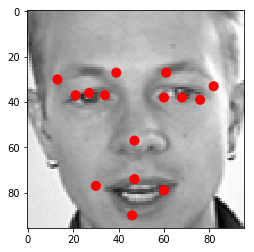

In [90]:
visualize_points(imgs_train[2], key_pts_train[2])

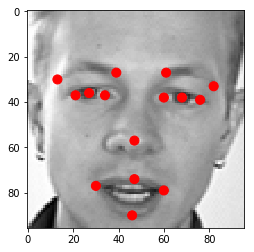

In [91]:
visualize_points(aug_imgs_train[2], aug_points_train[2])

In [92]:
from keras.models import Sequential
from keras.layers import (
    Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout
)

outputs = 28
input_shape = (100,100,3)

model = Sequential()
# Define here your model
model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same', input_shape = input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(outputs, activation='softmax'))
model.summary()

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 98, 98, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 49, 49, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 153664)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               19669120  
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________